In [1]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd
import pymeshlab as pml
import time
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_eigen_vectors(mesh):
    # Load the mesh with open3d
    
    # mesh.compute_vertex_normals()
    #mesh.rotate(mesh.get_rotation_matrix_from_xyz((0, np.pi/4, np.pi/5)))

    # Obtain numpy array containing the mesh's vertex positions.
    # Note: modifying values in the array will also change the corresponding vertex
    # positions in the mesh object
    vertices = np.asarray(mesh.vertices)

    # Compute barycenter
    barycenter = np.mean(vertices, axis=0)

    # Align mesh and vertices to origin
    vertices -= barycenter

    # Compute covariance matrix on vertices array
    cov = np.cov(vertices.transpose())

    # Compute eigen vectors and eigen values of covariance matrix
    # The eigen vectors are the columns of the returned 2d-array
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Order the eigenvectors according to the magnitude of their corresponding eigen value
    # (from largest to smallest)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(3)]
    eigencombined.sort(key=lambda x:x[0], reverse=True)
    eigenvectors = [item[1] for item in eigencombined]
    eigenvalues = [item[0] for item in eigencombined]

    # Replace the minor eigen vector with cross product of major and medium (to enforce right-handed reference frame)
    eigenvectors.pop(2)
    eigenvectors.append(np.cross(eigenvectors[0], eigenvectors[1]))

    eigvec_startpoint = np.zeros(3)
    eigvec_points = [eigvec_startpoint] + [vec for vec in eigenvectors]
    eigvec_line_indices = [[0, 1], [0, 2], [0, 3]]
    eigvec_lineset = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(eigvec_points),
        lines=o3d.utility.Vector2iVector(eigvec_line_indices),
    )

    # Add colors to the lines
    # Red, green, blue for major, 2nd-, and 3rd-largest eigen vectors, respectively. 
    line_colors = np.array([[255,0,0], [0,255,0], [0,0,255]])
    eigvec_lineset.colors = o3d.utility.Vector3dVector(line_colors)

    return eigenvectors, eigvec_lineset

### Statistics after resampling

***Test bary center normalization***

In [3]:
import math
def distance(x1, y1, z1, x2, y2, z2):
      
    d = math.sqrt(math.pow(x2 - x1, 2) +
                math.pow(y2 - y1, 2) +
                math.pow(z2 - z1, 2)* 1.0)
    return d

def center_test(dbpath):
    dist_to_center_list = []

    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                
                #compute mesh center and distance to origin, add this to the list
                mesh_center = mesh.get_center()
                dist = distance(mesh_center[0], mesh_center[1], mesh_center[2], 0, 0, 0)
                dist_to_center_list.append(dist)          
    return dist_to_center_list


In [4]:
#compute histogram for origional database
dbpath = r"./database/"
dist_to_center_list = center_test(dbpath)

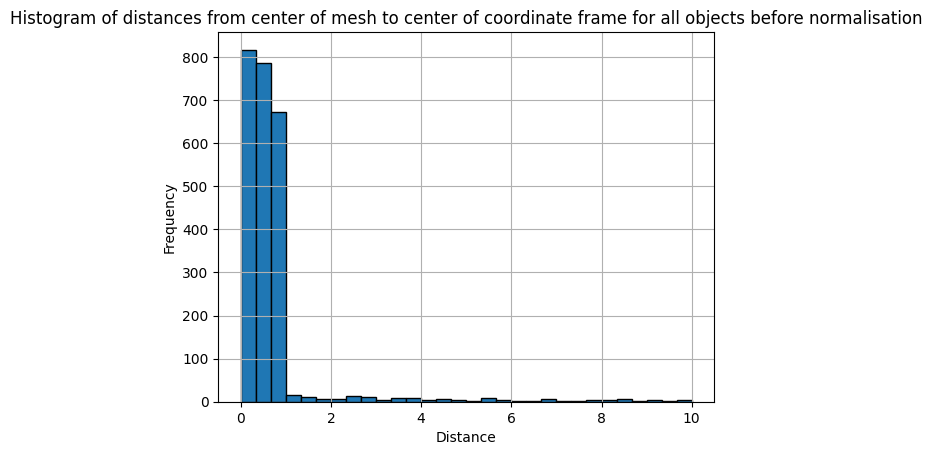

In [5]:
plt.hist(dist_to_center_list, bins=30, range=[0, 10], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Distance')
plt.title('Histogram of distances from center of mesh to center of coordinate frame for all objects before normalisation')
plt.grid(True)

# Display the histogram
plt.show()

In [6]:
#needs to be all 0 when centering is executed correctly
dbpath = r"./resampled3/"
dist_to_center_list_normailzed = center_test(dbpath)

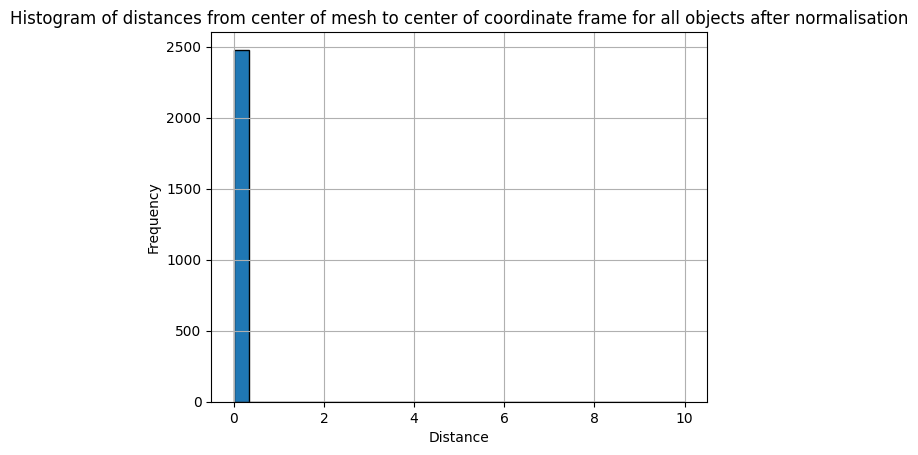

In [7]:

plt.hist(dist_to_center_list_normailzed, bins=30, range=[0, 10], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Distance')
plt.title('Histogram of distances from center of mesh to center of coordinate frame for all objects after normalisation')
plt.grid(True)

# Display the histogram
plt.show()

***Test rotation normalization***

In [4]:

# import required libraries
from numpy.linalg import norm

def cosine_similarity(v1, v2):
    cosine = np.dot(v1,v2)/(norm(v1)*norm(v2))
    return cosine
    
def test_rotation(dbpath):
    cosine_similarity_list = []
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])
    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                eigen_vectors,_ = get_eigen_vectors(mesh)
                print(eigen_vectors)
                x_similarity = cosine_similarity(x, eigen_vectors[0])
                y_similarity = cosine_similarity(y, eigen_vectors[1])
                z_similarity = cosine_similarity(z, eigen_vectors[2])
                cosine_similarity_list.append(x_similarity)
                cosine_similarity_list.append(y_similarity)
                cosine_similarity_list.append(z_similarity)
                
                print(x_similarity, y_similarity, z_similarity)
    return cosine_similarity_list

In [5]:
dbpath = r"./database/"
rotation_list = test_rotation(dbpath)

[array([ 1.37933137e-03, -9.99998671e-01, -8.68739279e-04]), array([-0.860536  , -0.00162949,  0.50938703]), array([-5.09387767e-01,  4.49679127e-05, -8.60537100e-01])]
0.00137933137058403 -0.0016294909791006432 -0.860537100208795
[array([ 1.08941545e-03, -9.99999204e-01, -6.36692685e-04]), array([-0.99985918, -0.00109992,  0.01674537]), array([-1.67460613e-02,  6.18360358e-04, -9.99859584e-01])]
0.0010894154538565132 -0.0010999245768555305 -0.999859583672866
[array([ 0.00532142,  0.99998422, -0.00179977]), array([0.00995386, 0.00174674, 0.99994893]), array([ 0.9999363 , -0.00533906, -0.0099444 ])]
0.005321418324273159 0.0017467389560633466 -0.00994440283759856
[array([0.00116887, 0.99999145, 0.00396722]), array([ 0.99997913, -0.00119405,  0.00634922]), array([ 0.00635391,  0.00395971, -0.99997197])]
0.0011688742834545976 -0.0011940488400643756 -0.9999719738859777
[array([-2.07843352e-04, -9.99999978e-01, -1.26114748e-08]), array([-9.99999978e-01,  2.07843352e-04,  1.48961560e-06]), ar

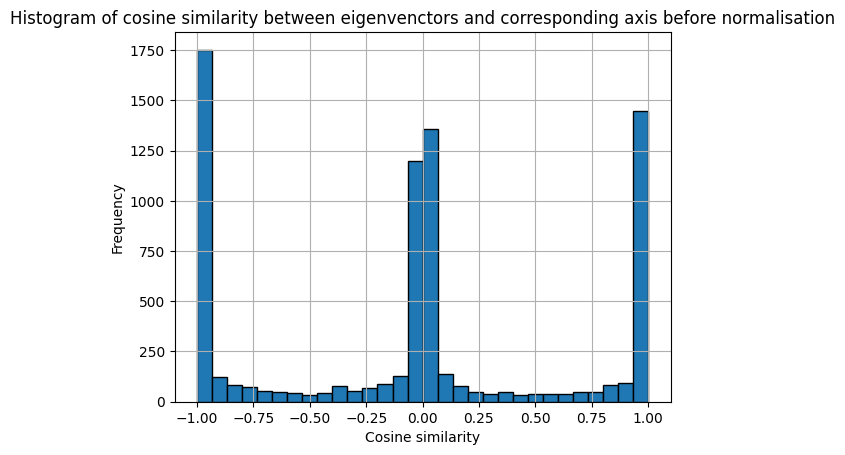

In [6]:
plt.hist(rotation_list, bins=30, edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Cosine similarity')
plt.title('Histogram of cosine similarity between eigenvenctors and corresponding axis before normalisation')
plt.grid(True)

# Display the histogram
plt.show()

In [7]:
dbpath = r"./resampled3/"
rotation_list_normalized = test_rotation(dbpath)

[array([1.00000000e+00, 2.97353222e-09, 5.26486185e-09]), array([ 2.97338864e-09, -1.00000000e+00,  2.72710110e-05]), array([ 5.26494294e-09, -2.72710110e-05, -1.00000000e+00])]
1.0 -0.9999999996281461 -0.9999999996281461
[array([ 1.00000000e+00,  2.10351391e-08, -7.57293367e-10]), array([ 2.10351593e-08, -1.00000000e+00,  2.66558529e-05]), array([-7.56732657e-10, -2.66558529e-05, -1.00000000e+00])]
0.9999999999999998 -0.9999999996447326 -0.9999999996447329
[array([ 1.00000000e+00,  2.54734270e-08, -3.96903115e-08]), array([-2.54734628e-08,  1.00000000e+00, -9.02123902e-07]), array([3.96902885e-08, 9.02123903e-07, 1.00000000e+00])]
0.9999999999999989 0.9999999999995928 0.9999999999995923
[array([ 1.00000000e+00,  7.86630015e-09, -8.68290236e-08]), array([-7.86638888e-09,  1.00000000e+00, -1.02183568e-06]), array([8.68290155e-08, 1.02183568e-06, 1.00000000e+00])]
0.9999999999999962 0.999999999999478 0.9999999999994743
[array([ 1.00000000e+00, -1.32001946e-07,  4.28666010e-08]), array([-

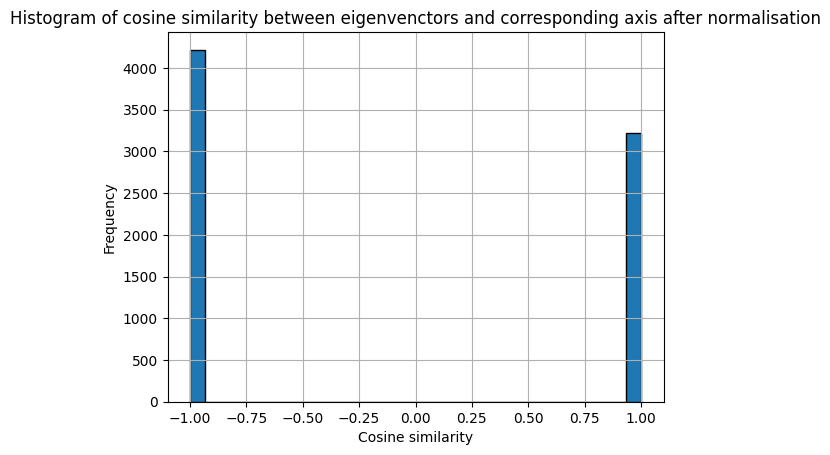

In [8]:
plt.hist(rotation_list_normalized, bins=30, edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Cosine similarity')
plt.title('Histogram of cosine similarity between eigenvenctors and corresponding axis after normalisation')
plt.grid(True)

# Display the histogram
plt.show()

***Test flip***

In [13]:
def test_flip(dbpath):
    mass_center_list = []

    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                mass = [0, 0, 0]
                for triangle in mesh.triangles:
                    center = [0, 0, 0]
                    for v in triangle:
                        vertex = mesh.vertices[v]
                        center += vertex
                    center = center / 3
                    
                    for i, C in enumerate(center):
                        mass[i] += np.sign(C) * (C * C)
                
                for i, C in enumerate(mass):
                    mass_center_list.append(C)

    return mass_center_list

In [14]:
#needs to be all negative when flipping is executed correctly
dbpath = r"./resampled3/"
flip_list_normalized = test_flip(dbpath)

In [15]:
max(flip_list_normalized)

1.2417025062563813e-05

In [16]:
num = 0
 
# using while loop     
while(num < len(flip_list_normalized)):
     
    # checking condition
    if flip_list_normalized[num] >= 0:
        print(flip_list_normalized[num], end = " ")
     
    # increment num 
    num += 1

9.235593323247103e-08 5.754996829053505e-06 1.2417025062563813e-05 

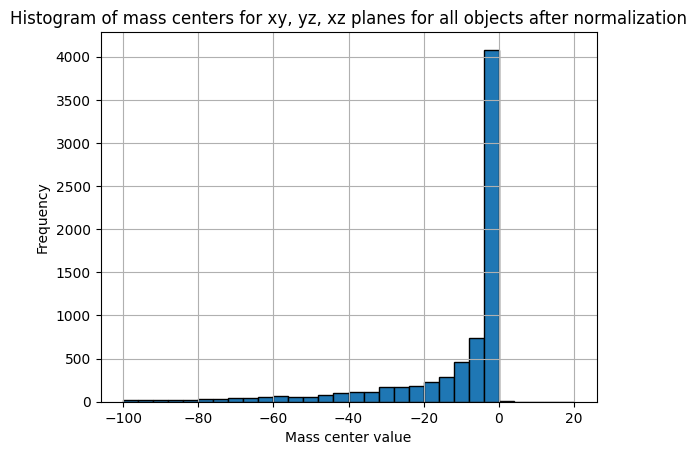

In [17]:
plt.hist(flip_list_normalized, bins=30, range=[-100,20], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Mass center value')
plt.title('Histogram of mass centers for xy, yz, xz planes for all objects after normalization')
plt.grid(True)

# Display the histogram
plt.show()

In [18]:
dbpath = r"./database/"
flip_list = test_flip(dbpath)

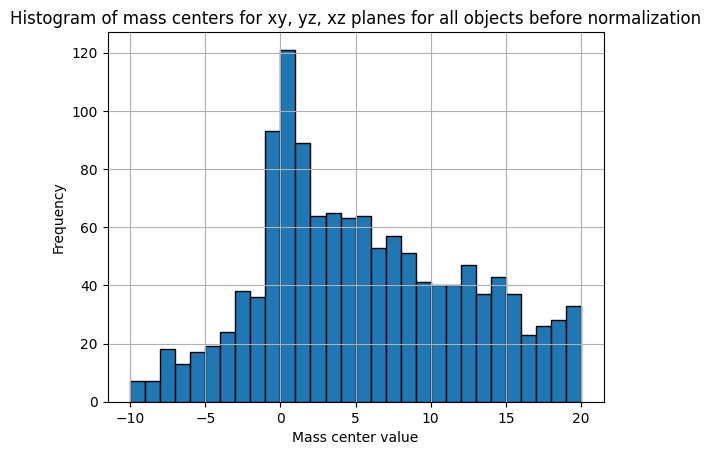

In [19]:
plt.hist(flip_list, bins=30, range=[-10,20], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Mass center value')
plt.title('Histogram of mass centers for xy, yz, xz planes for all objects before normalization')
plt.grid(True)

# Display the histogram
plt.show()

***test scaling***

In [20]:
def test_scaling(dbpath):
    max_length_list = []

    for class_folder in os.listdir(dbpath):
        # Construct the full path to the subfolder
        class_folder_path = os.path.join(dbpath, class_folder)
        
        # Check if the item in the directory is a directory (to skip files)
        if os.path.isdir(class_folder_path):
            # Assuming the class folder name is the class name
            class_name = class_folder
            
            # Iterate through .obj files in the subfolder
            for obj_file_path in glob.glob(os.path.join(class_folder_path, '*.obj')):
                mesh = o3d.io.read_triangle_mesh(obj_file_path)
                max_length = max(mesh.get_max_bound() - mesh.get_min_bound())
                max_length_list.append(max_length)
    return max_length_list

In [21]:
dbpath = r"./resampled3/"
max_length_list_normalized = test_scaling(dbpath)

0.9999999701976776


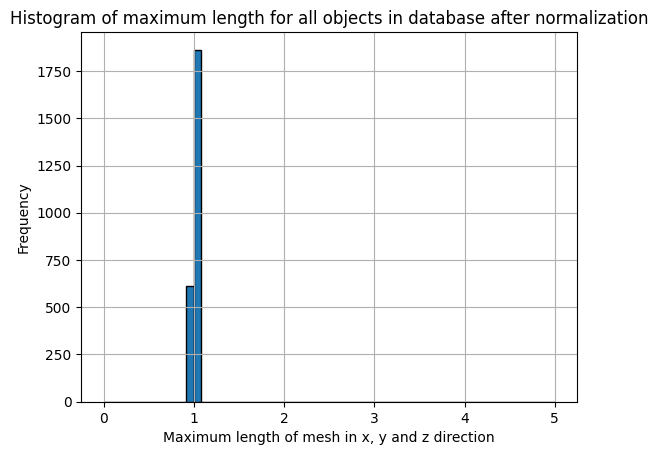

In [22]:
print(min(max_length_list_normalized))
plt.hist(max_length_list_normalized, bins=60, range = [0, 5], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Maximum length of mesh in x, y and z direction')
plt.title('Histogram of maximum length for all objects in database after normalization')
plt.grid(True)

# Display the histogram
plt.show()

In [23]:
dbpath = r"./database/"
max_length_list = test_scaling(dbpath)

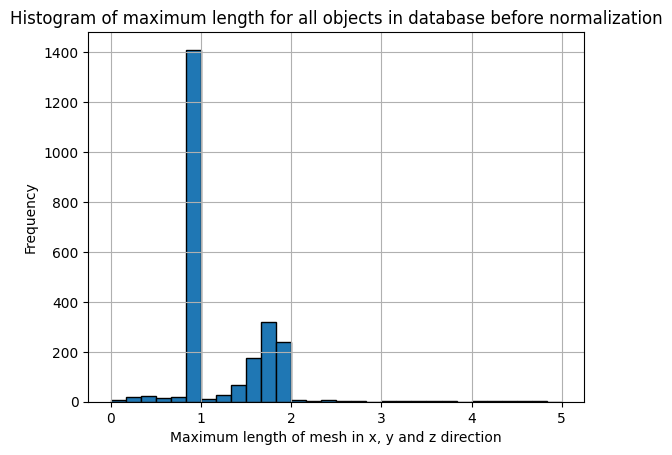

In [24]:
plt.hist(max_length_list, bins=30, range=[0,5], edgecolor='k')  
plt.ylabel('Frequency')
plt.xlabel('Maximum length of mesh in x, y and z direction')
plt.title('Histogram of maximum length for all objects in database before normalization')
plt.grid(True)

# Display the histogram
plt.show()